In [ ]:
!pip install easyocr

In [ ]:
import easyocr

In [ ]:
import albumentations as A

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from albumentations.pytorch import ToTensorV2
from random import sample
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ✅ Initialize OCR
reader = easyocr.Reader(['en'])

In [ ]:
import albumentations as A

train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.Perspective(scale=(0.05, 0.1), p=0.5),
    A.Affine(shear=(-10, 10), p=0.5)
])

In [ ]:
def extract_text(image_path):
    """Extract text from an image using OCR with augmentation."""
    image = cv2.imread(image_path)
    if image is None:
        return "image_not_found"

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Albumentations expects RGB

    # ✅ Apply distortion (augmentation)
    augmented = train_transform(image=image)
    distorted_image = augmented["image"]

    # ✅ Convert to grayscale for OCR
    gray = cv2.cvtColor(distorted_image, cv2.COLOR_RGB2GRAY)

    # ✅ OCR
    result = reader.readtext(gray)
    extracted_text = " ".join([res[1] for res in result])
    return extracted_text if extracted_text else "unknown"

def preprocess_text(text):
    """Clean and normalize extracted text."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9 ]', '', text)  # Remove special characters
    return text.strip()

# ✅ Define paths
train_images_path = "/content/drive/My Drive/train_images/"


In [ ]:
# ✅ Folder Name to Single-Letter Mapping (Direct Conversion)
folder_to_letter = {
    "F": "F",
    "C": "C",
    "H": "H",
    "O": "O",
    "P": "P",
    "S": "S",
    "U": "U"
}

In [ ]:
# ✅ Extract text and assign labels using folder mapping
text_data = []
labels = []
image_paths = []

for category in os.listdir(train_images_path):  # ✅ Folder name = True Label
    category_path = os.path.join(train_images_path, category)

    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # ✅ Extract text from image
            extracted_text = extract_text(img_path)
            clean_text = preprocess_text(extracted_text)

            if clean_text:  # ✅ Store only non-empty results
                text_data.append(clean_text)
                labels.append(folder_to_letter.get(category, "unknown"))  # ✅ Assign true label from folder
                image_paths.append(img_path)

# ✅ Convert to DataFrame
extracted_df = pd.DataFrame({"text": text_data, "label": labels, "image_path": image_paths})

# ✅ Remove unknowns
extracted_df = extracted_df[extracted_df["label"] != "unknown"]

# ✅ Display the Extracted Data
print("📊 Extracted Dataset with True Labels:")
print(extracted_df.head(60))  # Show first 10 rows

📊 Extracted Dataset with True Labels:
                text label                                         image_path
0                  u     U  /content/drive/My Drive/train_images/U/roi_38.png
1                  u     U  /content/drive/My Drive/train_images/U/roi_40.png
2                  u     U  /content/drive/My Drive/train_images/U/roi_42.png
3                  u     U  /content/drive/My Drive/train_images/U/roi_43.png
4                 iu     U  /content/drive/My Drive/train_images/U/roi_45.png
5                  u     U  /content/drive/My Drive/train_images/U/roi_46.png
6                  u     U  /content/drive/My Drive/train_images/U/roi_47.png
7                  u     U  /content/drive/My Drive/train_images/U/roi_51.png
8            unknown     U  /content/drive/My Drive/train_images/U/roi_52.png
9                  u     U  /content/drive/My Drive/train_images/U/newroi_...
10                 u     U  /content/drive/My Drive/train_images/U/newroi_...
11           unknown     U

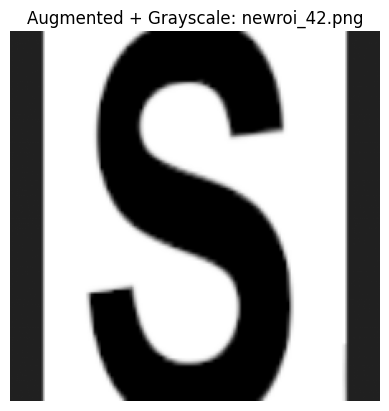

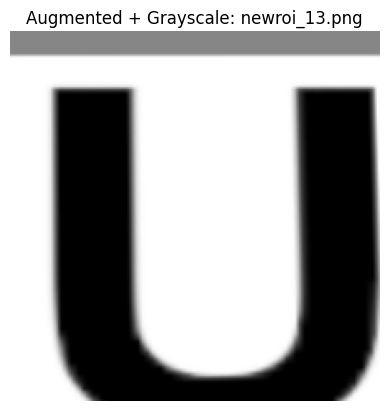

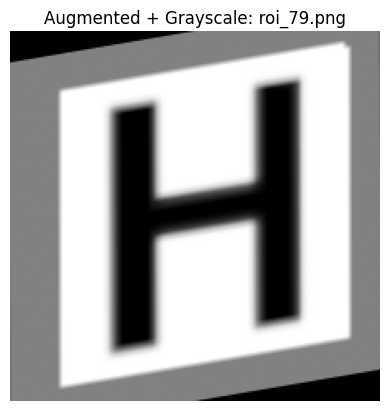

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
from random import sample

def show_augmented_image(image_path):
    """Load and display a preprocessed (augmented + grayscale) image."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Failed to load image: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = train_transform(image=image)
    distorted_image = augmented["image"]

    # ✅ Convert to grayscale after augmentation
    gray_image = cv2.cvtColor(distorted_image, cv2.COLOR_RGB2GRAY)

    plt.imshow(gray_image, cmap='gray')
    plt.title(f"Augmented + Grayscale: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Show 3 random augmented samples
random_images = sample(image_paths, 3)
for path in random_images:
    show_augmented_image(path)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# ✅ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    extracted_df["text"], extracted_df["label"], test_size=0.2, random_state=42
)

# ✅ Train Classifier with Single-Letter Fixes
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))  # ✅ Fixed TF-IDF
classifier = RandomForestClassifier(n_estimators=100)
pipeline = make_pipeline(vectorizer, classifier)
pipeline.fit(X_train, y_train)

# ✅ Evaluate Model Again
y_pred = pipeline.predict(X_test)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report (Fixed Single Letters):")
print(classification_report(y_test, y_pred))

✅ Accuracy: 0.9500

📊 Classification Report (Fixed Single Letters):
              precision    recall  f1-score   support

           C       1.00      1.00      1.00         3
           F       1.00      1.00      1.00         3
           H       1.00      1.00      1.00         3
           O       1.00      0.67      0.80         3
           P       1.00      1.00      1.00         2
           S       1.00      1.00      1.00         2
           U       0.80      1.00      0.89         4

    accuracy                           0.95        20
   macro avg       0.97      0.95      0.96        20
weighted avg       0.96      0.95      0.95        20



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


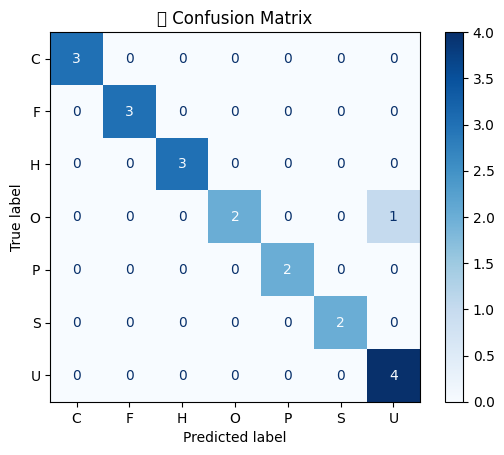

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues")
plt.title("📉 Confusion Matrix")
plt.show()

In [ ]:
import joblib

# ✅ Save the trained model
joblib.dump(pipeline, "text_classifier.pkl")
print("✅ Model Saved: text_classifier.pkl")

✅ Model Saved: text_classifier.pkl


In [ ]:
# ✅ Define Save Path in Google Drive
model_save_path = "/content/drive/My Drive/text_classifier.pkl"

# ✅ Save the trained model
joblib.dump(pipeline, model_save_path)

print(f"✅ Model Saved to Google Drive: {model_save_path}")


🔍 Running OCR & Classification on All Test Images...



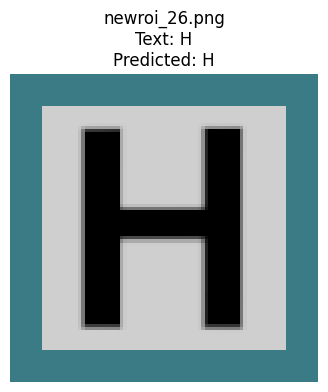

📌 Image: newroi_26.png
🔍 Extracted Text: H
✅ Predicted Class: H
--------------------------------------------------


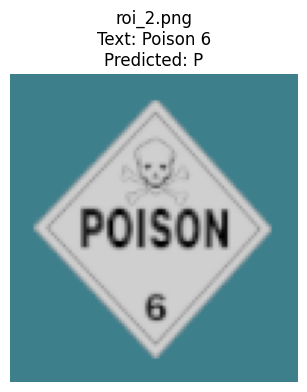

📌 Image: roi_2.png
🔍 Extracted Text: Poison 6
✅ Predicted Class: P
--------------------------------------------------


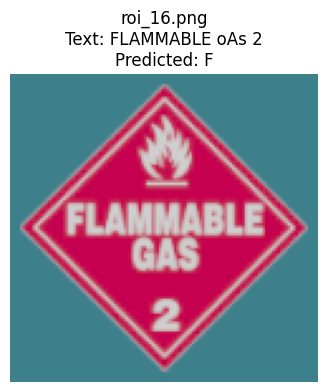

📌 Image: roi_16.png
🔍 Extracted Text: FLAMMABLE oAs 2
✅ Predicted Class: F
--------------------------------------------------


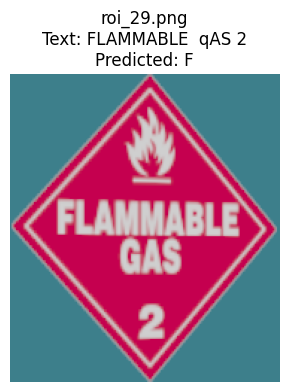

📌 Image: roi_29.png
🔍 Extracted Text: FLAMMABLE  qAS 2
✅ Predicted Class: F
--------------------------------------------------


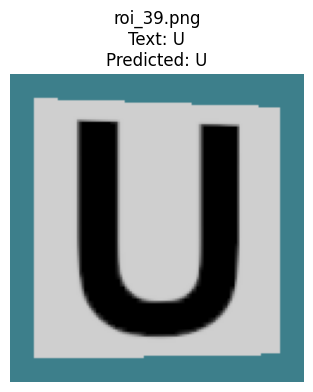

📌 Image: roi_39.png
🔍 Extracted Text: U
✅ Predicted Class: U
--------------------------------------------------


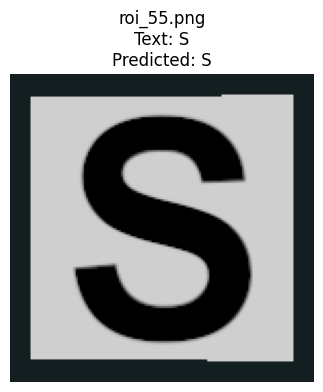

📌 Image: roi_55.png
🔍 Extracted Text: S
✅ Predicted Class: S
--------------------------------------------------


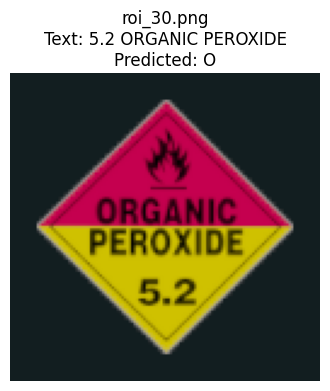

📌 Image: roi_30.png
🔍 Extracted Text: 5.2 ORGANIC PEROXIDE
✅ Predicted Class: O
--------------------------------------------------


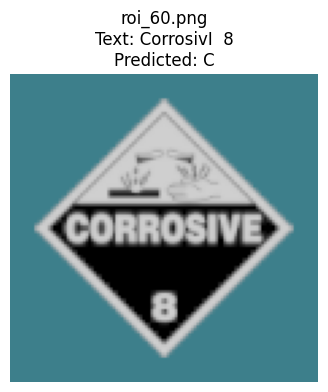

📌 Image: roi_60.png
🔍 Extracted Text: CorrosivI  8
✅ Predicted Class: C
--------------------------------------------------


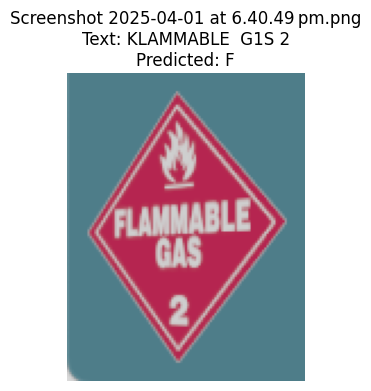

📌 Image: Screenshot 2025-04-01 at 6.40.49 pm.png
🔍 Extracted Text: KLAMMABLE  G1S 2
✅ Predicted Class: F
--------------------------------------------------


In [ ]:
# ✅ Load the trained model
pipeline = joblib.load("text_classifier.pkl")

test_images_path = "/content/drive/My Drive/test_images/"

# ✅ Function to classify all test images with single-letter output
def classify_all_test_images_with_display():
    """Classify test images and display them with their predicted class and extracted text."""
    print("\n🔍 Running OCR & Classification on All Test Images...\n")

    for img_name in os.listdir(test_images_path):
        img_path = os.path.join(test_images_path, img_name)

        if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            extracted_text = extract_text(img_path)
            clean_text = preprocess_text(extracted_text)
            predicted_class = pipeline.predict([clean_text])[0]

            single_letter_class = folder_to_letter.get(predicted_class, "Unknown")

            # ✅ Load image for display
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # ✅ Display using matplotlib
            plt.figure(figsize=(4, 4))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"{img_name}\nText: {extracted_text}\nPredicted: {single_letter_class}")
            plt.show()

            # ✅ Also print results in text
            print(f"📌 Image: {img_name}")
            print(f"🔍 Extracted Text: {extracted_text}")
            print(f"✅ Predicted Class: {single_letter_class}")
            print("-" * 50)

# ✅ Run classification and display results
classify_all_test_images_with_display()